# Hierarchical Logistic regression with Binomial family

This notebook shows how to build a hierarchical logistic regression model with the Binomial family in Bambi.

This example is based on the [Hierarchical baseball](https://ericmjl.github.io/bayesian-analysis-recipes/notebooks/hierarchical-baseball/) article in [Bayesian Analysis Recipes](https://ericmjl.github.io/bayesian-analysis-recipes/), a collection of articles on how to do Bayesian data analysis with PyMC3 made by [Eric Ma](https://ericmjl.github.io/).

## Problem description

Extracted from the original work:

>>Baseball players have many metrics measured for them. Let’s say we are on a baseball team, and would like to quantify player performance, one metric being their batting average (defined by how many times a batter hit a pitched ball, divided by the number of times they were up for batting (“at bat”)). How would you go about this task?

## Load libraries and data

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
random_seed = 1234

We first need some measurements of batting data. Today we’re going to use data from the [Baseball Databank](https://github.com/chadwickbureau/baseballdatabank). It is a compilation of historical baseball data in a convenient, tidy format, distributed under Open Data terms.

This repository contains several datasets in the form of ```.csv``` files. This example is going to use the ```Batting.csv``` file, which can be loaded directly with Bambi in a convenient way.

In [3]:
df = bmb.load_data("batting")

# Then clean some of the data
df["AB"] = df["AB"].replace(0, np.nan)
df = df.dropna()
df["batting_avg"] = df["H"] / df["AB"]
df = df[df["yearID"] >= 2016]
df = df.iloc[0:15] 
df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,batting_avg
101348,abadfe01,2016,1,MIN,AL,39,1.0,0,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
101350,abreujo02,2016,1,CHA,AL,159,624.0,67,183,32,...,0.0,2.0,47,125.0,7.0,15.0,0.0,9.0,21.0,0.293269
101352,ackledu01,2016,1,NYA,AL,28,61.0,6,9,0,...,0.0,0.0,8,9.0,0.0,0.0,0.0,1.0,0.0,0.147541
101353,adamecr01,2016,1,COL,NL,121,225.0,25,49,7,...,2.0,3.0,24,47.0,0.0,4.0,3.0,0.0,5.0,0.217778
101355,adamsma01,2016,1,SLN,NL,118,297.0,37,74,18,...,0.0,1.0,25,81.0,1.0,2.0,0.0,3.0,5.0,0.249158


From all the columns above, we’re going to use the following:

* ```playerID```: Unique identification for the player.
* ```AB```: Number of times the player was up for batting.
* ```H```: Number of times the player hit the ball while batting.
* ```batting_avg```: Simply ratio between ```H``` and ```AB```.

## Explore our data

It’s always good to explore the data before starting to write down our models. This is very useful to gain a good understanding of the distribution of the variables and their relationships, and even anticipate some problems that may occur during the sampling process.

The following graph summarizes the percentage of hits, as well as the number of times the players were up for batting and the number of times they hit the ball.

In [4]:
BLUE = "#2a5674"
RED = "#b13f64"

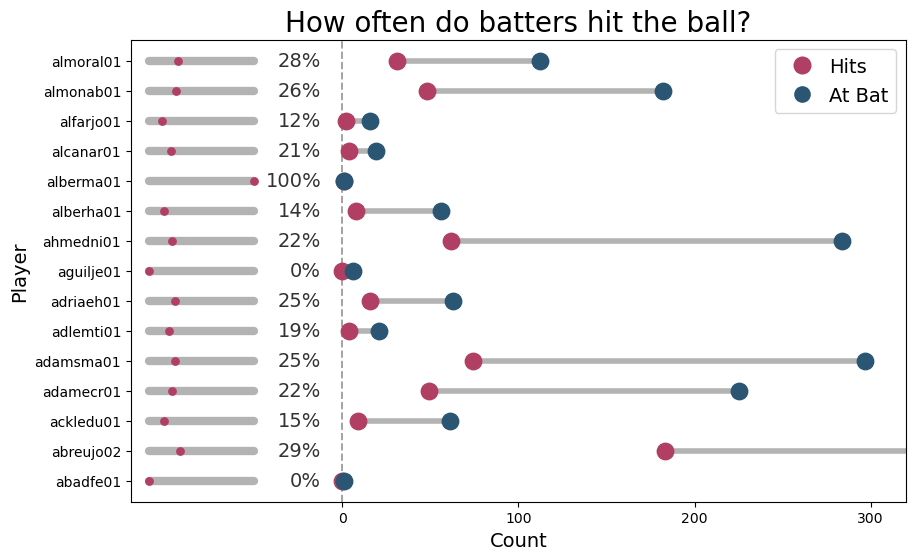

In [5]:
_, ax = plt.subplots(figsize=(10, 6))

# Customize x limits. 
# This adds space on the left side to indicate percentage of hits.
ax.set_xlim(-120, 320)

# Add dots for the the number of hits and the times at bat
ax.scatter(df["H"], list(range(15)), s=140, color=RED, zorder=10)
ax.scatter(df["AB"], list(range(15)), s=140, color=BLUE, zorder=10)

# Also a line connecting them
ax.hlines(list(range(15)), df["H"], df["AB"], color="#b3b3b3", lw=4)

ax.axvline(ls="--", lw=1.4, color="#a3a3a3")
ax.hlines(list(range(15)), -110, -50, lw=6, color="#b3b3b3", capstyle="round")
ax.scatter(60 * df["batting_avg"] - 110, list(range(15)), s=28, color=RED, zorder=10)

# Add the percentage of hits
for j in range(15): 
    text = f"{round(df['batting_avg'].iloc[j] * 100)}%"
    ax.text(-12, j, text, ha="right", va="center", fontsize=14, color="#333")

# Customize tick positions and labels
ax.yaxis.set_ticks(list(range(15)))
ax.yaxis.set_ticklabels(df["playerID"])
ax.xaxis.set_ticks(range(0, 400, 100))

# Create handles for the legend (just dots and labels)
handles = [
    Line2D(
        [0], [0], label="Hits", marker="o", color="None", markeredgewidth=0, 
        markerfacecolor=RED, markersize=13
    ),
    Line2D(
        [0], [0], label="At Bat", marker="o", color="None", markeredgewidth=0,
        markerfacecolor=BLUE, markersize=12
    )
]

# Add legend on top-right corner
legend = ax.legend(
    handles=handles, 
    loc=1, 
    fontsize=14, 
    handletextpad=0.4,
    frameon=True
)

# Finally add labels and a title
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Player", fontsize=14)
ax.set_title("How often do batters hit the ball?", fontsize=20);

The first thing one can see is that the number of times players were up for batting varies quite a lot. Some players have been there for very few times, while there are others who have been there hundreds of times. We can also note the percentage of hits is usually a number between 12% and 29%.

There are two players, **alberma01** and **abadfe01**, who had only one chance to bat. The first one hit the ball, while the latter missed. That’s why **alberma01** as a 100% hit percentage, while **abadfe01** has 0%. There’s another player, **aguilje01**, who has a success record of 0% because he missed all the few opportunities he had to bat. These extreme situations, where the empirical estimation lives in the boundary of the parameter space, are associated with estimation problems when using a maximum-likelihood estimation approach. Nonetheless, they can also impact the sampling process, especially when using wide priors.

As a final note, **abreujo02**, has been there for batting 624 times, and thus the grey dot representing this number does not appear in the plot.

## Non-hierarchical model

Let’s get started with a simple cell-means logistic regression for $p_i$, the probability of hitting the ball for the player $i$

$$
\textrm{logit} ( p_i ) = \beta_i, \ \textrm{with} \ i = 0, \cdots , 14
$$

Where
$$
\beta_i \sim \textrm{Normal} ( 0, \sigma_{\beta} )
$$

$\sigma_{\beta}$ is a common constant for all the players, and $\textrm{logit} ( p_i ) = \textrm{log} \frac{ p_i }{ 1 - p_i}$.

Specifying this model is quite simple in Bambi thanks to its formula interface.

First of all, note this is a Binomial family and the response involves both the number of hits (```H```) and the number of times at bat (```AB```). We use the ```p(x, n)``` function for the response term. This just tells Bambi we want to model the proportion resulting from dividing x over n.

The right-hand side of the formula is ```"0 + playerID"```. This means the model includes a coefficient for each player ID, but does not include a global intercept.

Finally, using the Binomial family is as easy as passing ```family="binomial"```. By default, the link function for this family is ```link="logit"```, so there’s nothing to change there.

In [6]:
model_non_hierarchical = bmb.Model("p(H, AB) ~ 0 + playerID", df, family="binomial")
model_non_hierarchical

       Formula: p(H, AB) ~ 0 + playerID
        Family: binomial
          Link: p = logit
  Observations: 15
        Priors: 
    target = p
        Common-level effects
            playerID ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [10.0223 10.0223
                10.0223 10.0223 10.0223 10.0223 10.0223 10.0223 10.0223
             10.0223 10.0223 10.0223 10.0223 10.0223 10.0223])

In [7]:
idata_non_hierarchical = model_non_hierarchical.fit(random_seed=random_seed, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.54,7
,2000,0,0.46,7
,2000,0,0.51,7
,2000,0,0.51,7


Next we observe the posterior of the coefficient for each player. The ```compact=False``` argument means we want separated panels for each player.

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


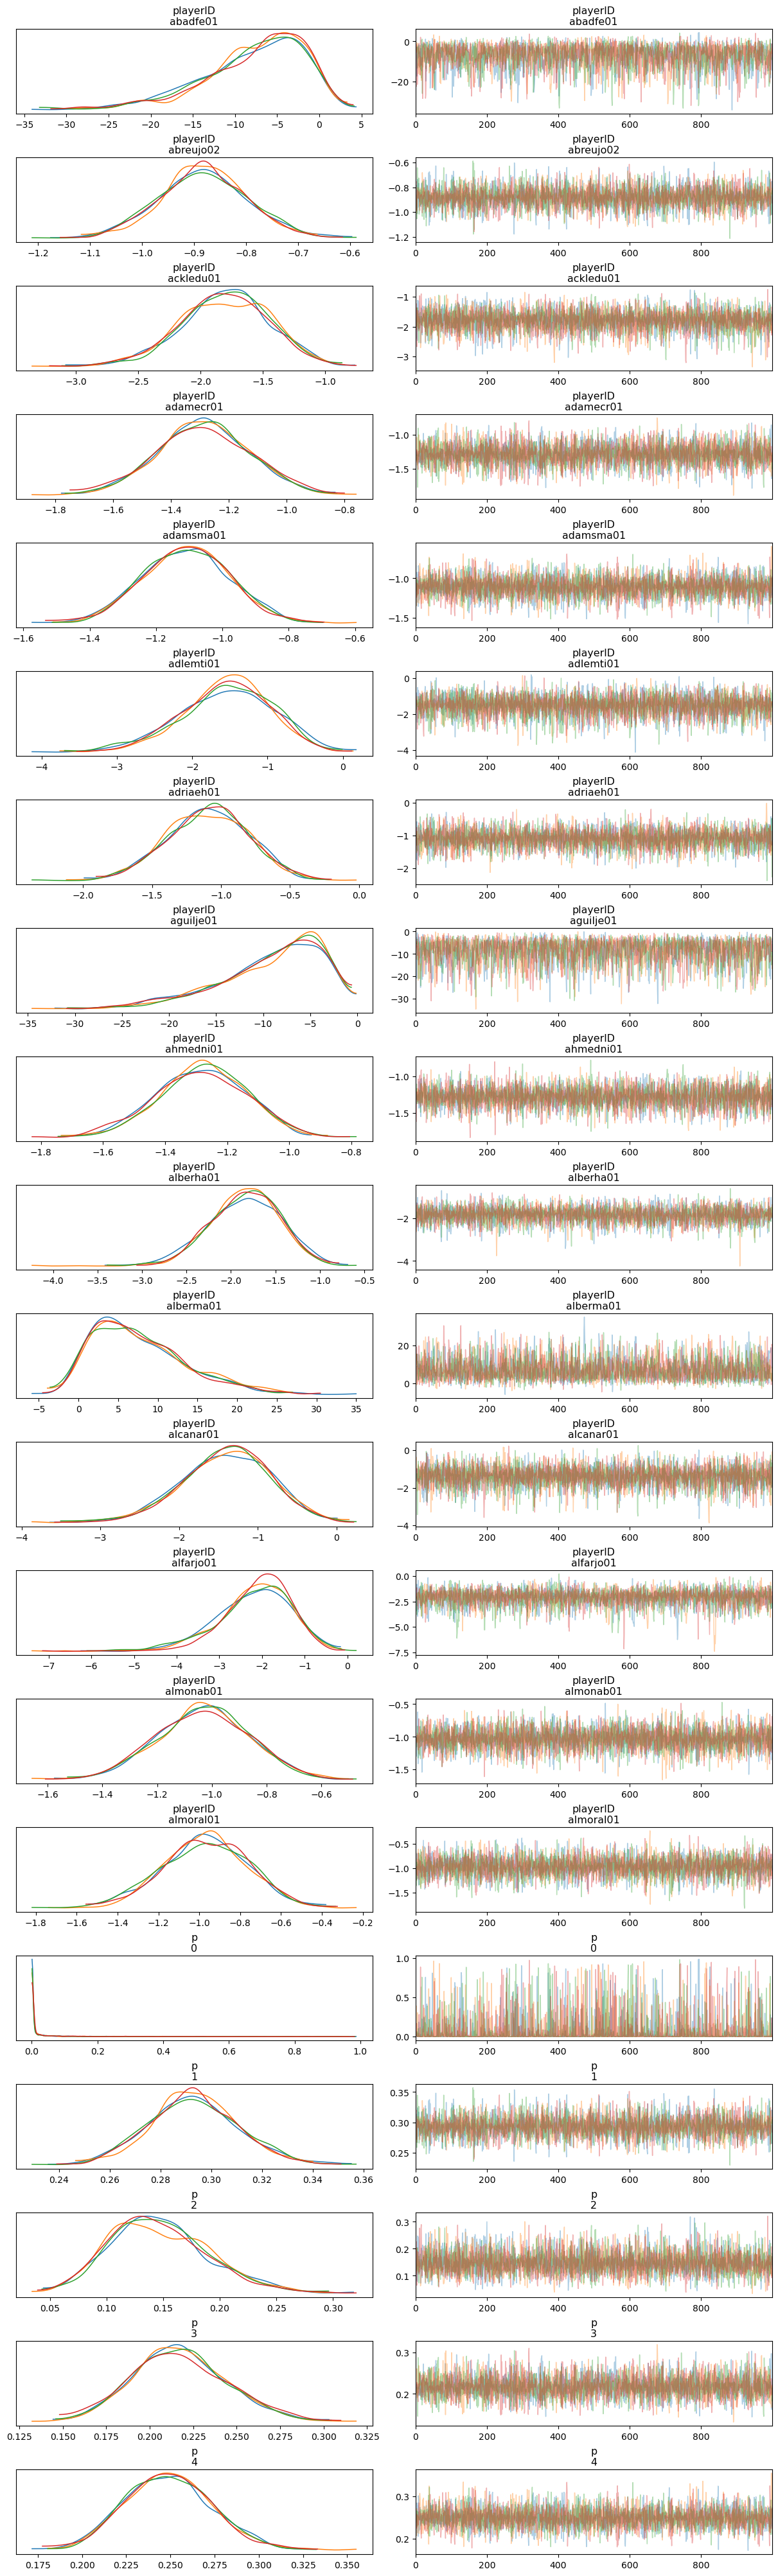

In [8]:
az.plot_trace(idata_non_hierarchical, compact=False, backend_kwargs={"layout": "constrained"});

So far so good! The traceplots indicate the sampler worked well.

Now, let’s keep this posterior aside for later use and let’s fit the hierarchical version.

## Hierarchical model

This model incorporates a group-specific intercept for each player:

$$
\textrm{logit} ( p_i ) = \alpha + \gamma_i
$$

where

$$
\begin{align}
\alpha \sim &= \textrm{Normal} (0, \sigma_{\alpha}) \\

\gamma \sim &= \textrm{Normal} (0, \sigma_{\gamma}) \\

\sigma_{\gamma} &= \textrm{HalfNormal} (\tau) \\

\end{align}
$$

The group-specific terms are indicated with the | operator in the formula. In this case, since there is an intercept for each player, we write ```1|playerID```.

In [9]:
model_hierarchical = bmb.Model("p(H, AB) ~ 1 + (1|playerID)", df, family="binomial")
model_hierarchical

       Formula: p(H, AB) ~ 1 + (1|playerID)
        Family: binomial
          Link: p = logit
  Observations: 15
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|playerID ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))

In [10]:
idata_hierarchical = model_hierarchical.fit(random_seed=random_seed, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.49,7
,2000,1,0.56,7
,2000,0,0.50,7
,2000,1,0.49,7


Sometimes, there can be several [divergences](https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html) when fitting a hierarchical model. What can we do in that case?

One thing we could try is increasing ```target_accept```. But if there are many divergences, that suggests a problem with the underlying model. Let’s take a look at the prior predictive distribution to see whether our priors are too informative or too wide.

The ```Model``` instance has a method called ```prior_predictive()``` that generates samples from the prior predictive distribution. It returns an ```InferenceData``` object that contains the values of the prior predictive distribution.

In [11]:
idata_prior = model_hierarchical.prior_predictive()
prior = az.extract_dataset(idata_prior, group="prior_predictive")["p(H, AB)"]

Sampling: [1|playerID_offset, 1|playerID_sigma, Intercept, p(H, AB)]
C:\Users\treme\AppData\Local\Temp\ipykernel_1864\2686921361.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  prior = az.extract_dataset(idata_prior, group="prior_predictive")["p(H, AB)"]


If we inspect the DataArray, we see there are 500 draws (```sample```) for each of the 15 players (```__obs__```)

Let’s plot these distributions together with the observed proportion of hits for every player here.

In [12]:
# We define this function because this plot is going to be repeated below.
def plot_prior_predictive(df, prior):
    AB = df["AB"].values
    H = df["H"].values

    fig, axes = plt.subplots(5, 3, figsize=(10, 6), sharex="col")

    for idx, ax in enumerate(axes.ravel()):
        pps = prior.sel({"__obs__":idx})
        ab = AB[idx]
        h = H[idx]
        hist = ax.hist(pps / ab, bins=25, color="#a3a3a3")
        ax.axvline(h / ab, color=RED, lw=2)
        ax.set_yticks([])
        ax.tick_params(labelsize=12)
    
    fig.subplots_adjust(left=0.025, right=0.975, hspace=0.05, wspace=0.05, bottom=0.125)
    fig.legend(
        handles=[Line2D([0], [0], label="Observed proportion", color=RED, linewidth=2)],
        handlelength=1.5,
        handletextpad=0.8,
        borderaxespad=0,
        frameon=True,
        fontsize=11, 
        bbox_to_anchor=(0.975, 0.92),
        loc="right"
        
    )
    fig.text(0.5, 0.05, "Prior probability of hitting", fontsize=15, ha="center", va="baseline")

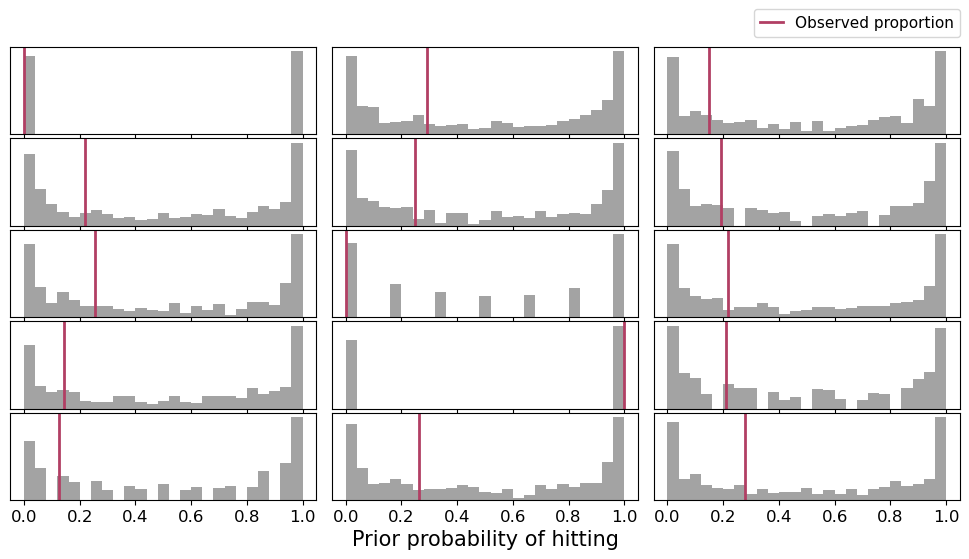

In [13]:
plot_prior_predictive(df, prior)

Indeed, priors are too wide! Let’s use tighter priors and see what’s the result

In [14]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "1|playerID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))
}
model_hierarchical = bmb.Model("p(H, AB) ~ 1 + (1|playerID)", df, family="binomial", priors=priors)
model_hierarchical

       Formula: p(H, AB) ~ 1 + (1|playerID)
        Family: binomial
          Link: p = logit
  Observations: 15
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|playerID ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))

Now let’s check the prior predictive distribution for these new priors.

Sampling: [1|playerID_offset, 1|playerID_sigma, Intercept, p(H, AB)]
C:\Users\treme\AppData\Local\Temp\ipykernel_1864\1302716284.py:3: FutureWarning: extract_dataset has been deprecated, please use extract
  prior = az.extract_dataset(idata_prior, group="prior_predictive")["p(H, AB)"]


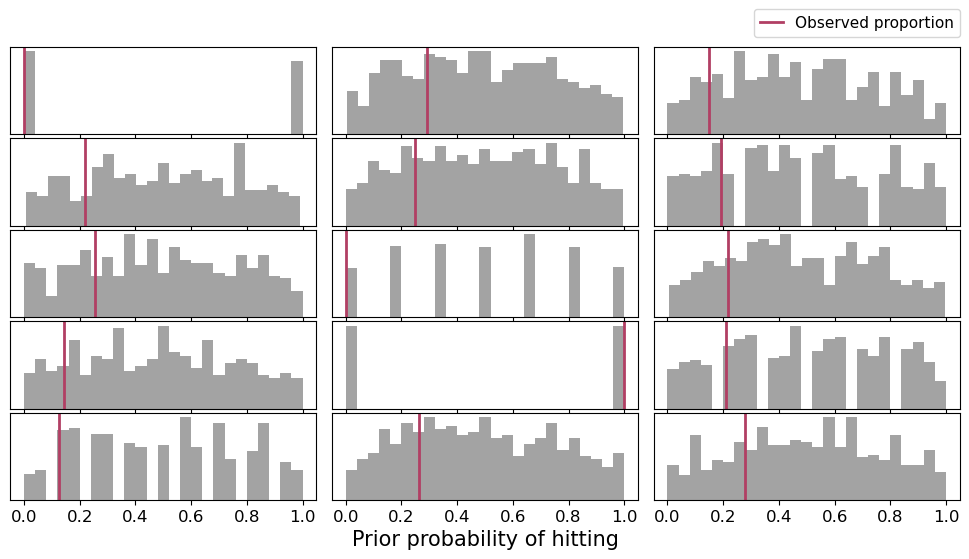

In [15]:
model_hierarchical.build()
idata_prior = model_hierarchical.prior_predictive()
prior = az.extract_dataset(idata_prior, group="prior_predictive")["p(H, AB)"]
plot_prior_predictive(df, prior)

Definetely it looks much better. Now the priors tend to have a symmetric shape with a mode at 0.5, with substantial probability on the whole domain.

In [16]:
idata_hierarchical = model_hierarchical.fit(random_seed=random_seed, nuts_sampler = "nutpie")

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:303: UserWarning: `var_names` are currently ignored by the nutpie sampler
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.50,15
,2000,1,0.48,7
,2000,0,0.52,7
,2000,1,0.54,7


Let’s try with increasing ```target_accept``` and the number of ```tune``` samples.

In [17]:
idata_hierarchical = model_hierarchical.fit(tune=2000, draws=2000, target_accept=0.95, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|playerID_sigma, 1|playerID_offset]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


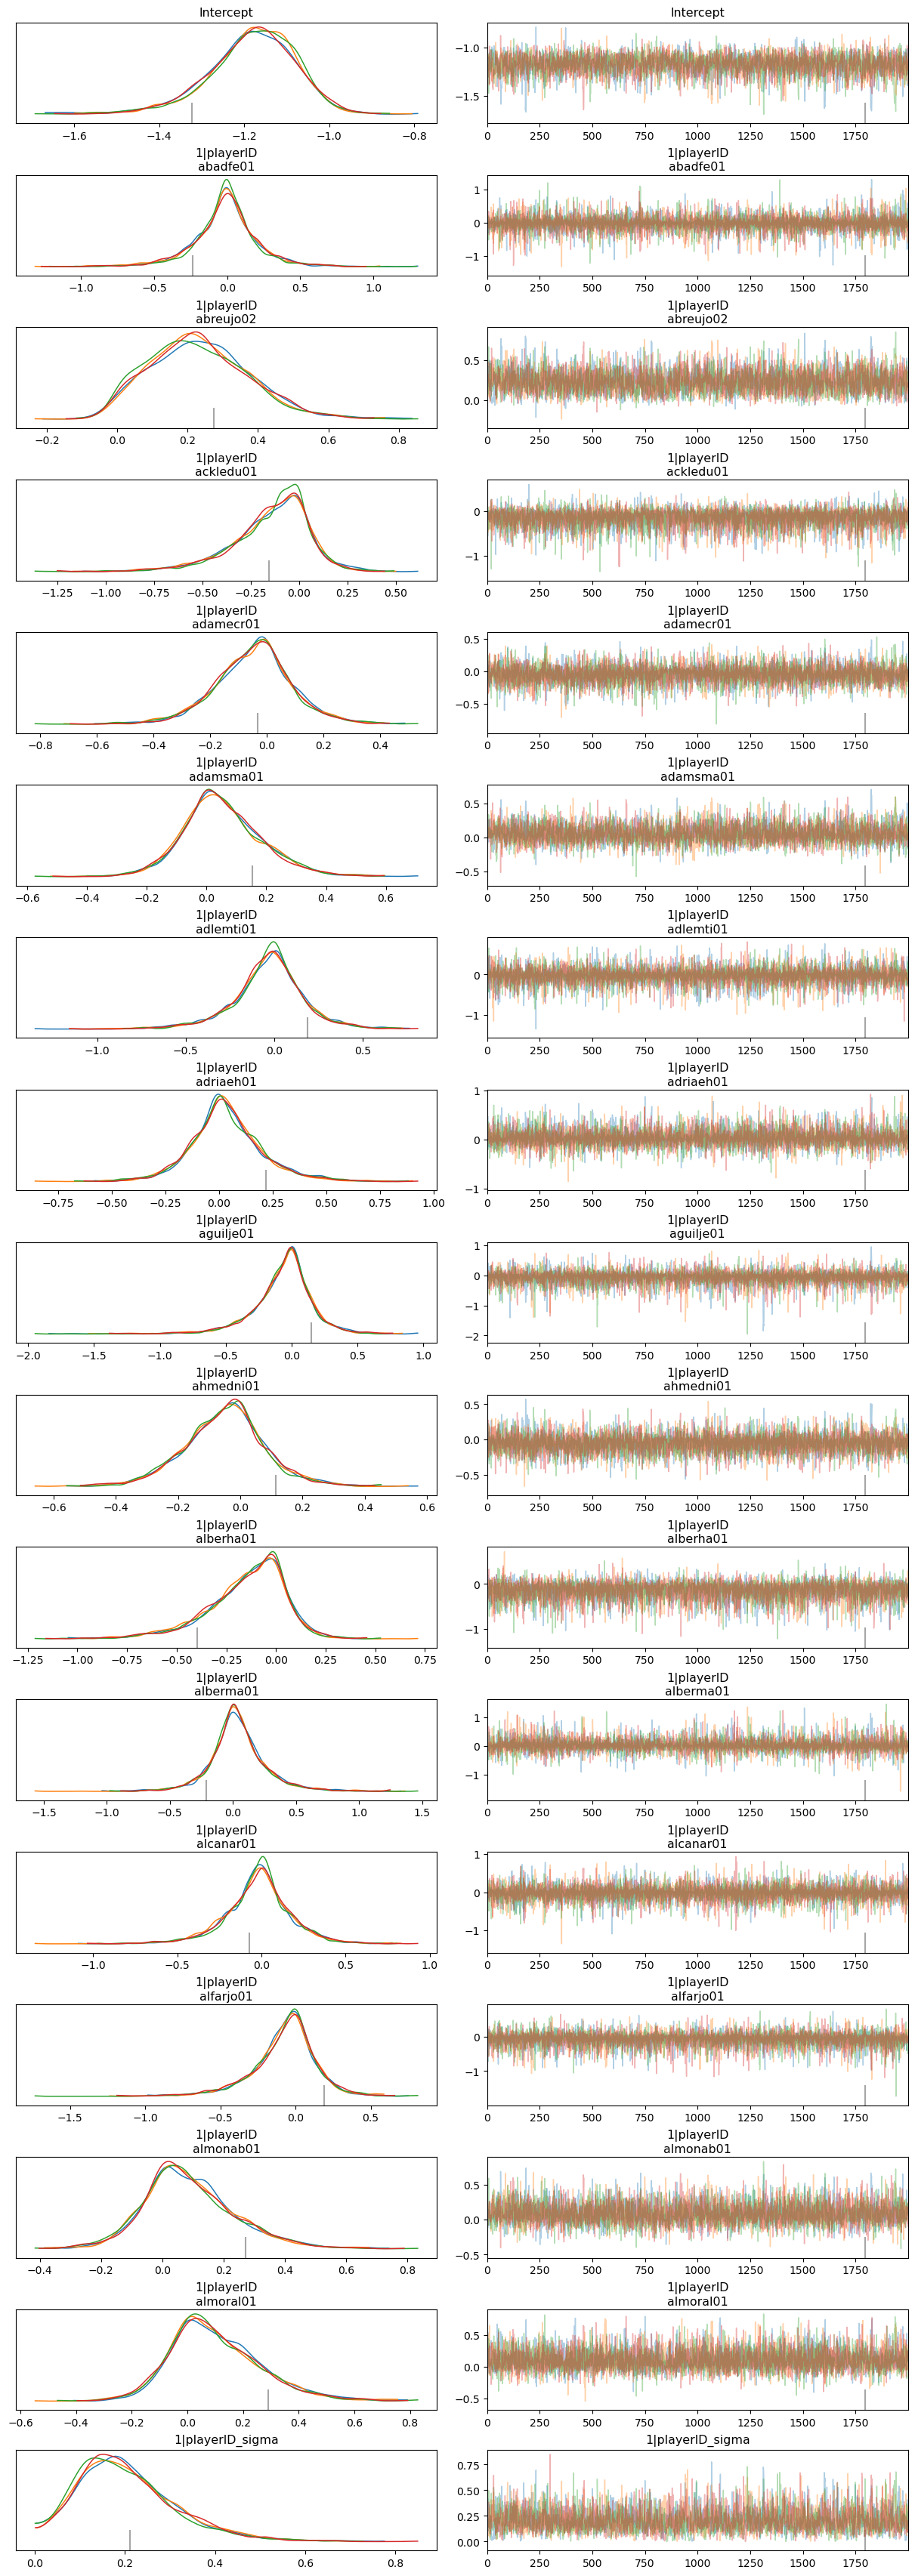

In [18]:
var_names = ["Intercept", "1|playerID", "1|playerID_sigma"]
az.plot_trace(idata_hierarchical, var_names=var_names, compact=False, backend_kwargs={"layout": "constrained"});

Let’s jump onto the next section where we plot and compare the probability of hit for the players using both models.

## Compare predictions

Now we’re going to plot the distribution of the probability of hit for each player, using both models.

But before doing that, we need to obtain the posterior in that scale. We could manually take the posterior of the coefficients, compute the linear predictor, and transform that to the probability scale. But that’s a lot of work!

Fortunately, Bambi models have a method called ```.predict()``` that we can use to predict in the probability scale. By default, it modifies in-place the ```InferenceData``` object we pass to it. Then, the posterior samples can be found in the variable ```p```.

In [19]:
model_non_hierarchical.predict(idata_non_hierarchical)
model_hierarchical.predict(idata_hierarchical)

Let’s create a forestplot using the posteriors obtained with both models so we can compare them very easily .

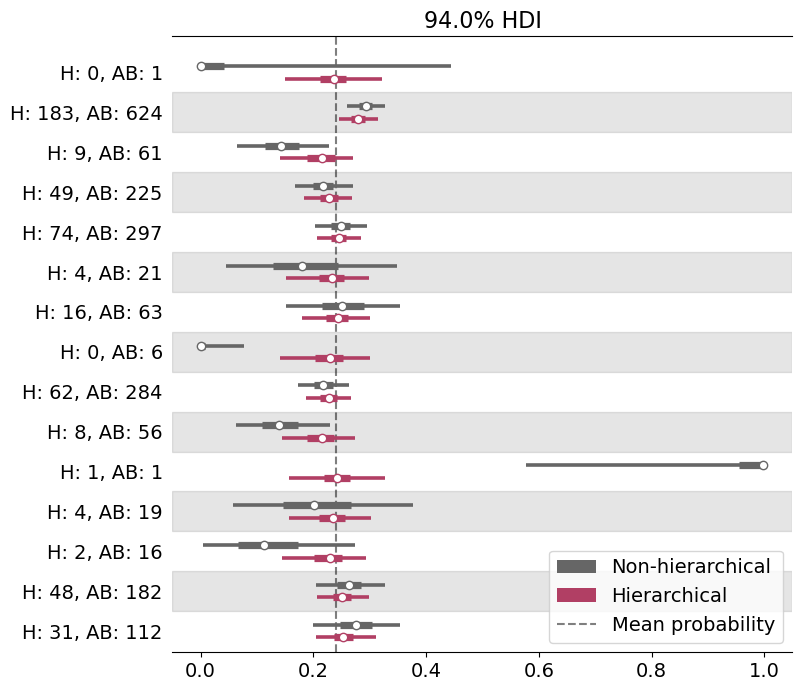

In [20]:
_, ax = plt.subplots(figsize = (8, 8))

# Add vertical line for the global probability of hitting
ax.axvline(x=(df["H"] / df["AB"]).mean(), ls="--", color="black", alpha=0.5)

# Create forestplot with ArviZ, only for the mean.
az.plot_forest(
    [idata_non_hierarchical, idata_hierarchical], 
    var_names="p", 
    combined=True, 
    colors=["#666666", RED], 
    linewidth=2.6, 
    markersize=8,
    ax=ax
)

# Create custom y axis tick labels
ylabels = [f"H: {round(h)}, AB: {round(ab)}" for h, ab in zip(df["H"].values, df["AB"].values)]
ylabels = list(reversed(ylabels))

# Put the labels for the y axis in the mid of the original location of the tick marks.
ax.set_yticklabels(ylabels, ha="right")

# Create legend
handles = [
    Patch(label="Non-hierarchical", facecolor="#666666"),
    Patch(label="Hierarchical", facecolor=RED),
    Line2D([0], [0], label="Mean probability", ls="--", color="black", alpha=0.5)
]

legend = ax.legend(handles=handles, loc=4, fontsize=14, frameon=True, framealpha=0.8);

One of the first things one can see is that not only the center of the distributions varies but also their dispersion. Those posteriors that are very wide are associated with players who have batted only once or few times, while tighter posteriors correspond to players who batted several times.

Players who have extreme empirical proportions have similar extreme posteriors under the non-hierarchical model. However, under the hierarchical model, these distributions are now **shrunk towards the global mean**. Extreme values are very unlikely under the hierarchical model.

And finally, paraphrasing Eric, there’s nothing ineherently right or wrong about shrinkage and hierarchical models. Whether this is reasonable or not depends on our prior knowledge about the problem. And to me, after having seen the hit rates of the other players, it is much more reasonable to shrink extreme posteriors based on very few data points towards the global mean rather than just let them concentrate around 0 or 1.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 06 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

arviz     : 0.20.0
bambi     : 0.14.0
matplotlib: 3.9.2
numpy     : 1.26.4

Watermark: 2.5.0

